In [2]:
import numpy as np
import pandas as pd
import math

from scipy import stats
from statsmodels.tsa.api import adfuller, kpss, acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import het_arch
from arch import arch_model

import pandas_datareader.data as web

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
sns.set()

# Data  
We use the log returns we already computed.

In [3]:
data = web.DataReader('APU0000710212', 'fred', start='1991')
data.tail()

,APU0000710212
DATE,
2025-05-01,5.908
2025-06-01,5.999
2025-07-01,6.041
2025-08-01,6.123
2025-09-01,6.049


In [4]:
data = data.copy()
data.rename(columns={'APU0000710212': 'Cheddar Price (100g)'}, inplace=True)

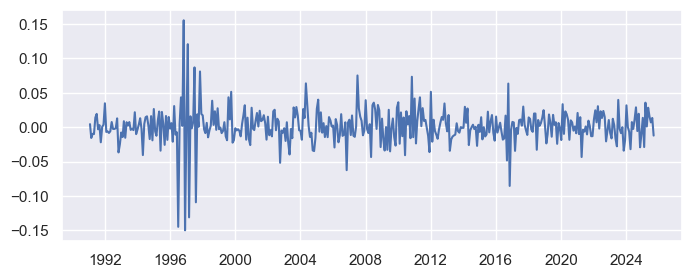

In [5]:
data['Log Returns'] = np.log(data['Cheddar Price (100g)'] / data['Cheddar Price (100g)'].shift(1))

fig, ax = plt.subplots(figsize=(8,3))
line = ax.plot(data['Log Returns'])

We copy the Cheddar returns in a new `pandas.Series` for our analysis
To avoid the estimation of the mean, we first center the series.  
Also, some numerical method in the `arch` library work better with data grater than 1, hence we scale the percent returns.

In [6]:
x = data['Log Returns'].dropna().copy()
x = x - x.mean()
x *= 100
x.head()

DATE
1991-02-01    0.319387
1991-03-01   -1.691580
1991-04-01   -1.088460
1991-05-01   -1.126562
1991-06-01    1.273072
Name: Log Returns, dtype: float64

# Stationarity

In [8]:
def print_adf_test(x):
    regressions = {'constant only': 'c',
                   'constant and trend': 'ct',
                   'no constant, no trend': 'n'}
    df = pd.DataFrame(data=np.zeros((len(regressions),2)),
                      index=regressions,
                      columns=['test statistic', 'p-value'])
    for reg in regressions:
        res = adfuller(x, regression=regressions[reg])
        df.loc[reg, 'test statistic'] = res[0]
        df.loc[reg, 'p-value'] = res[1]
    display(df.round(4))
    return df

def print_kpss_test(x, regression='c'):
    regressions = {'constant only': 'c',
                   'constant and trend': 'ct'}
    df = pd.DataFrame(data=np.zeros((len(regressions),2)),
                      index=regressions,
                      columns=['test statistic', 'p-value'])
    for reg in regressions:
        res = kpss(x, regression=regressions[reg], nlags='auto')
        df.loc[reg, 'test statistic'] = res[0]
        df.loc[reg, 'p-value'] = res[1]
    display(df.round(4))
    return df

In [9]:
res = print_adf_test(x)

,test statistic,p-value
constant only,-12.5349,0.0
constant and trend,-12.5221,0.0
"no constant, no trend",-12.5501,0.0


In [10]:
res = print_kpss_test(x)

C:\Users\jeanb\AppData\Local\Temp\ipykernel_72740\2621098583.py:22: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  res = kpss(x, regression=regressions[reg], nlags='auto')


,test statistic,p-value
constant only,0.0384,0.1
constant and trend,0.0362,0.1


Both tests conclude that there is strong evidence in the sample that log returns are stationary.

# Autoregressive Conditional Heteroscedasticity

## Autocorrelation of returns and squared returns

Plots of the returns and squared returns, highlighting the returns that are greater than 3% in absolute value.  
Observe the **clustering** of such values, indicative of **ARCH effect**.

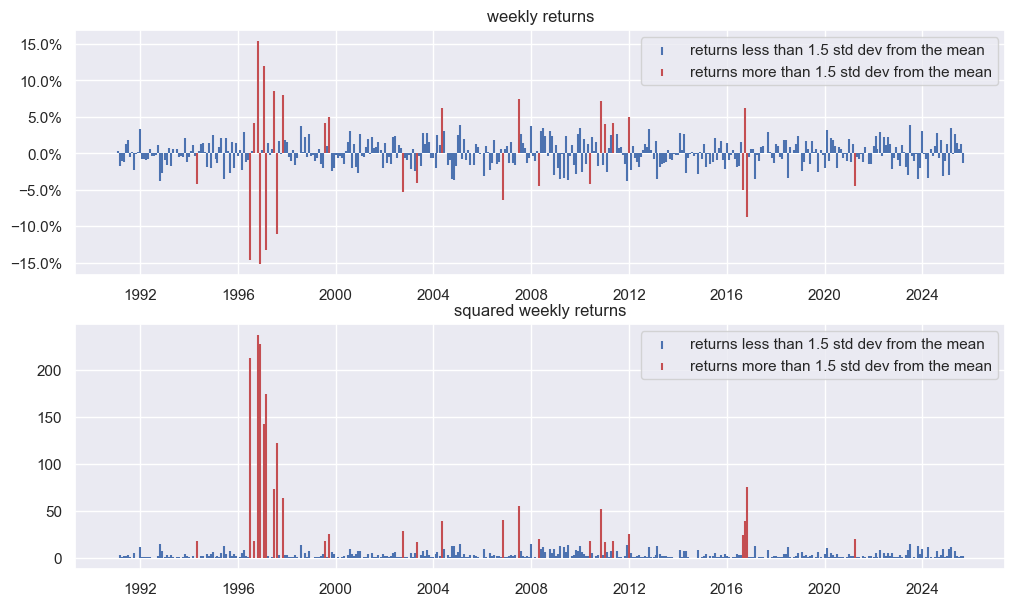

In [11]:
coeff = 1.5
mask = np.abs(x) > coeff * x.std()

fig, ax = plt.subplots(2, figsize=(12, 7))

ax[0].stem(x[~mask].index, x[~mask].values, linefmt='b-', markerfmt=' ', basefmt=' ', label=f"returns less than {coeff} std dev from the mean")
ax[0].stem(x[mask].index, x[mask].values, linefmt='r-', markerfmt=' ', basefmt=' ', label=f"returns more than {coeff} std dev from the mean")
ax[0].set_title('weekly returns')
ax[0].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=100))

ax[1].stem(x[~mask].index, x[~mask].values ** 2, linefmt='b-', markerfmt=' ', basefmt=' ', label=f"returns less than {coeff} std dev from the mean")
ax[1].stem(x[mask].index, x[mask].values ** 2, linefmt='r-', markerfmt=' ', basefmt=' ', label=f"returns more than {coeff} std dev from the mean")
ax[1].set_title('squared weekly returns')

ax[0].legend()
ax[1].legend();

### Autocorrelation and Partial Autocorrelation Functions

The clustering of periods of high and low volatility are confirmed by the ACF and PACF.

In [12]:
def acf_pacf(x, lags=50):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    plot_acf(x, lags=lags, ax=ax[0])
    plot_pacf(x, lags=lags, ax=ax[1], method='ywm')
    
    # add the 95% confidence interval using variance = 1/N
    stderr = stats.norm.ppf(.975) / np.sqrt(len(x))
    ax[0].hlines([stderr, -stderr], 0, lags, colors='r', linestyles='dotted', label='95% confidence interval')
    ax[1].hlines([stderr, -stderr], 0, lags, colors='r', linestyles='dotted', label='95% confidence interval')
    
    ax[0].legend()
    ax[1].legend()
    
    return fig

Apply the function to the returns.  
Autocorrelation at lag 1 and lag 8 seem to be **statistically significant**. However they may not be **practically significant**. Returns are very close to White Noise.

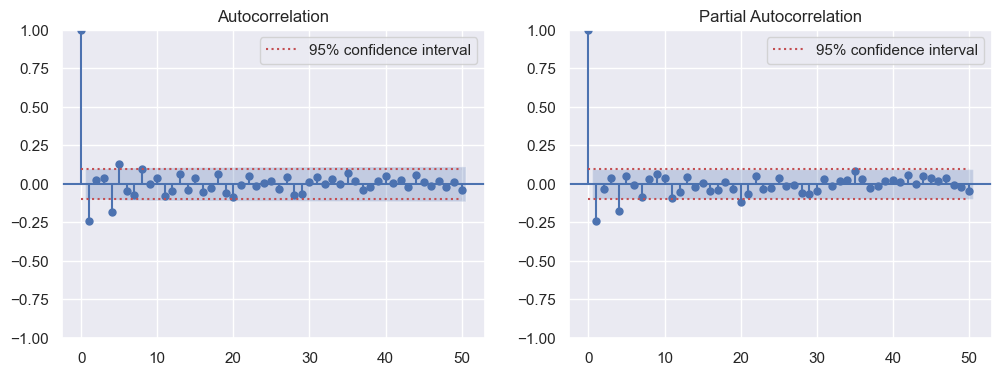

In [13]:
fig = acf_pacf(x)

Apply the function to the squared returns.  
**Squared returns exhibit serial corelation**.

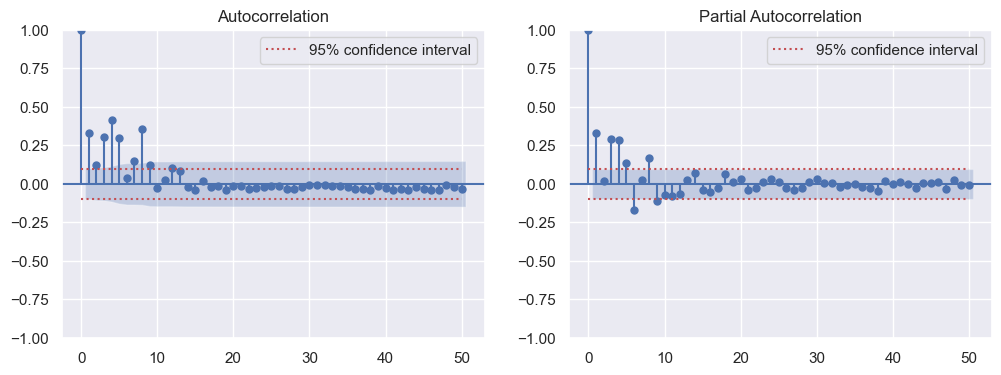

In [14]:
fig = acf_pacf(x**2)

### Ljung-Box Q test for autocorrelation

In [15]:
def print_acf(x, lags):
    val, qstat, pval = acf(x, fft=False, qstat=True, nlags=lags.max())
    df = pd.DataFrame(np.array([qstat[lags-1], 100 * pval[lags-1]]).T,
                      columns=['Q Statistic', 'p-value (%)'],
                      index=[f'up to lag {lag}' for lag in lags]).round(2)
    display(df)
    return df

In [16]:
test_lags = np.array([1, 2, 3, 5, 10])
res = print_acf(x , lags=test_lags)

,Q Statistic,p-value (%)
up to lag 1,24.07,0.0
up to lag 2,24.36,0.0
up to lag 3,24.90,0.0
up to lag 5,45.99,0.0
up to lag 10,54.02,0.0


Apply to the squared returns.  
Here we clearly reject the Null Hypothesis.

In [17]:
res = print_acf(x**2 , lags=test_lags)

,Q Statistic,p-value (%)
up to lag 1,45.81,0.0
up to lag 2,52.33,0.0
up to lag 3,91.68,0.0
up to lag 5,202.08,0.0
up to lag 10,273.32,0.0


Based on the Ljung-Box test, we reject H0, as p_value is inferior to 5%. However, to assume no autocorrelation, the results of the test should have been superior to 5%. 
Therefore we cannot conclude that there is no autocorrelation

## Engle’s Test for Autoregressive Conditional Heteroscedasticity
<https://www.statsmodels.org/stable/generated/statsmodels.stats.diagnostic.het_arch.html>  

*The Null Hypothesis is that there is no ARCH effect*.

In [18]:
def print_engle_test(x):
    res = het_arch(x, nlags=min(10, len(x)//5))
    df = pd.DataFrame(data = np.array(res).reshape(2,2),
                      columns=['test statistic', 'p-value'],
                      index=['Lagrange Multiplier', 'F test'])
    print("Engle's ARCH Test")
    display(df.round(4))
    return df

Apply to the returns.

In [19]:
res = print_engle_test(x)

Engle's ARCH Test


,test statistic,p-value
Lagrange Multiplier,128.9320,0.0
F test,18.3811,0.0


As the p_value is inferior to 5%, we reject H0, so we assume there's an ARCH effect.

# Fitting a GARCH(p,q) model

**Note**: *In the `arch` library, the parameter $p$ is for the number of ARCH lags and the parameter $q$ is for the number of GARCH lags.*  

We use a GARCH($p, q$) model with a mean equal to 0 with the parameter `mean='Zero'`. The returns are driven by the following equations:  
$$\begin{align}
r_t &= \sigma_t \varepsilon_t\\
\sigma_t^2 &= \omega + \sum_{i=1}^p \alpha_i r_{t-i}^2  + \sum_{j=1}^q \beta_j \sigma_{t-j}^2
\end{align}$$   

We use the `arch` library.
1. create an `ARCHmodel object` using the model constructor `arch_model()`.
2. use the `fit()` method of the `ARCHmodel object` and store the result.
3. the result is an object of the class `ARCHModelResult` that we can now use.

*links:*
- Introduction to ARCH Models: https://arch.readthedocs.io/en/latest/univariate/introduction.html#arch.univariate.arch_model
- `arch` library: https://arch.readthedocs.io/en/latest/index.html
- `ARCHModel` class: https://arch.readthedocs.io/en/latest/univariate/generated/arch.univariate.base.ARCHModel.html
  - `fit` method of the class: https://arch.readthedocs.io/en/latest/univariate/generated/generated/arch.univariate.base.ARCHModel.fit.html
  - `ARCHModelResult` class: https://arch.readthedocs.io/en/latest/univariate/generated/arch.univariate.base.ARCHModelResult.html

## Selecting a model with Information Criteria

This function estimate some GARCH models and store their AIC and BIC values in two DataFrame.

In [23]:
def select_garch(x, max_arch=2, max_garch=2, mean='Zero'):
    """
    Compute and store the AIC and BIC values for all GARCH models
    with 1 <= ARCH lags  <= max_arch
    and  0 <= GARCH lags <= max_garch
    Returns two DataFrames, first with AIC values, second with BIC values
    """
    # create the row and columns indices for the DataFrame
    row_index = pd.Index(data=np.arange(max_arch)+1, name='ARCH Lags')
    col_index = pd.Index(data=np.arange(max_garch+1), name='GARCH Lags')
    
    # create the DataFrames with zeros everywhere
    aic = pd.DataFrame(data=np.zeros((max_arch, max_garch+1)),
                       index=row_index,
                       columns=col_index)
    bic = pd.DataFrame(data=np.zeros((max_arch, max_garch+1)),
                       index=row_index,
                       columns=col_index)
    
    # loop on ARCH lags and GARCH lags
    for i in range(max_arch):
        for j in range(max_garch+1):
            # estimate the model and save AIC and BIC
            model = arch_model(x, p=i+1, q=j, mean=mean)
            res = model.fit(update_freq=0, disp='off')
            aic.iloc[i, j] = res.aic
            bic.iloc[i, j] = res.bic
    
    # find the row and column index of the minimum value in the AIC DataFrame
    # and store the corresponding order of the GARCH model in a tuple
    r_min, c_min = np.unravel_index(np.argmin(aic), aic.shape)
    aic_min_order = (row_index[r_min], col_index[c_min])
    
    # same for BIC
    r_min, c_min = np.unravel_index(np.argmin(bic), bic.shape)
    bic_min_order = (row_index[r_min], col_index[c_min])
    
    # display the results
    display(aic.round(1))
    print(f'AIC selected order: {aic_min_order}')
    display(bic.round(1))
    print(f'BIC selected order: {bic_min_order}')
    
    # return the two DataFrame
    return aic, bic

Apply this function to our data.

In [24]:
aic, bic = select_garch(x, max_arch=4, max_garch=3, mean='Zero')

GARCH Lags,0,1,2,3
ARCH Lags,,,,
1,1944.0,1877.2,1879.2,1878.4
2,1920.5,1878.6,1879.0,1879.1
3,1917.8,1874.9,1876.9,1878.9
4,1869.8,1871.6,1873.6,1875.6


AIC selected order: (np.int64(4), np.int64(0))


GARCH Lags,0,1,2,3
ARCH Lags,,,,
1,1952.1,1889.3,1895.4,1898.6
2,1932.6,1894.7,1899.1,1903.3
3,1933.9,1895.0,1901.1,1907.1
4,1889.9,1895.7,1901.8,1907.8


BIC selected order: (np.int64(1), np.int64(1))


## Fit the models selected by AIC and BIC for comparison
Use the  `summary()` method of the `ARCHModelResult` object to display the estimated model.  
https://arch.readthedocs.io/en/latest/univariate/generated/arch.univariate.base.ARCHModelResult.html

Fit a **GARCH(1,1)** model to the data.

In [25]:
model = arch_model(x, p=1, q=1, mean='Zero')
res_garch11 = model.fit()

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1936.5668167553636
Iteration:      2,   Func. Count:     12,   Neg. LLF: 1020.166932926234
Iteration:      3,   Func. Count:     18,   Neg. LLF: 1041.7419668671548
Iteration:      4,   Func. Count:     23,   Neg. LLF: 935.9182029794862
Iteration:      5,   Func. Count:     27,   Neg. LLF: 935.658167749395
Iteration:      6,   Func. Count:     31,   Neg. LLF: 935.6384627766478
Iteration:      7,   Func. Count:     35,   Neg. LLF: 935.6282458447722
Iteration:      8,   Func. Count:     39,   Neg. LLF: 935.6185820661268
Iteration:      9,   Func. Count:     43,   Neg. LLF: 935.6184924896233
Iteration:     10,   Func. Count:     47,   Neg. LLF: 935.6184912685342
Iteration:     11,   Func. Count:     50,   Neg. LLF: 935.6184912685924
Optimization terminated successfully    (Exit mode 0)
            Current function value: 935.6184912685342
            Iterations: 11
            Function evaluations: 50
            Gradient evaluations: 1

In [26]:
res_garch11.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:            Log Returns   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.002
Vol Model:                      GARCH   Log-Likelihood:               -935.618
Distribution:                  Normal   AIC:                           1877.24
Method:            Maximum Likelihood   BIC:                           1889.33
                                        No. Observations:                  416
Date:                Sun, Nov 02 2025   Df Residuals:                      416
Time:                        19:43:42   Df Model:                            0
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.7582      0.271      2.801  5.096e-03   [  0.228,  1.289]
alpha[1]       0.1287  4.271e-02      3.013  2.586e-03 [4.498e-02,  0.212]
beta[1]        0.7428  5.262e-02     14.117  2.991e-45   [  0.640,  0.846]
==========================================================================

Covariance estimator: robust
"""

##  Residuals analysis

We study the **standardized residuals**, that is $\varepsilon_t = r_t / \sigma_t$, which are in the `std_resid` attribute of the `ARCHModelResult` class.

In [27]:
res_garch11.std_resid

DATE
1991-02-01    0.178269
1991-03-01   -0.952258
1991-04-01   -0.584287
1991-05-01   -0.603174
1991-06-01    0.679258
                ...   
2025-05-01    1.167202
2025-06-01    0.587827
2025-07-01    0.249867
2025-08-01    0.564317
2025-09-01   -0.636800
Name: std_resid, Length: 416, dtype: float64

### Normality  

The following function plots:
1. an histogram of the data with the KDE and the best fit by a Normal distribution
2. a Normal Probability Plot

In [28]:
def hist_probplot(data, bins='auto'):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    
    sns.histplot(data=data, bins=bins, kde=True, stat='density', ax=ax[0], label="data")
    xmin, xmax = ax[0].get_xlim()
    x = np.linspace(xmin, xmax, 200)
    y = stats.norm.pdf(x, loc=data.mean(), scale=data.std(ddof=0))
    ax[0].plot(x, y, 'r', label="best Normal fit")
    ax[0].legend()

    stats.probplot(data, plot=ax[1])
    
    return fig

Apply this function to the standardized residuals of `res_garch11` with `bins=30`.

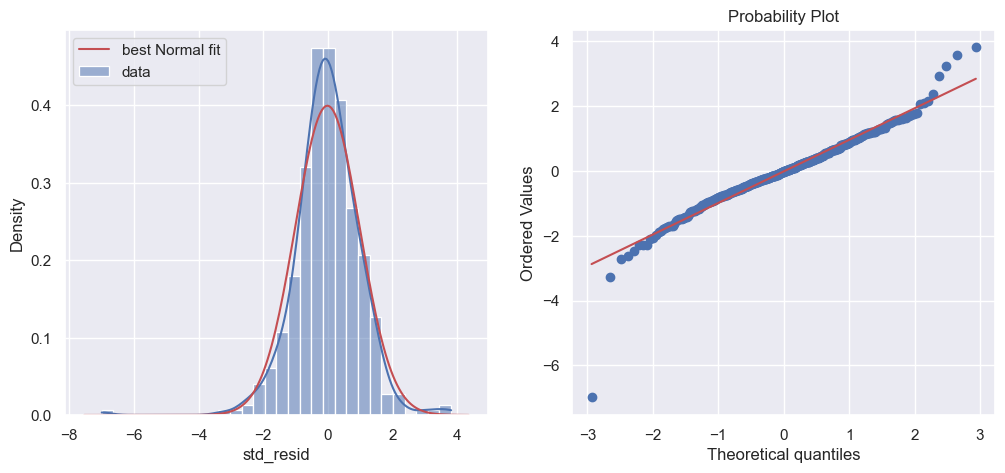

In [29]:
fig = hist_probplot(res_garch11.std_resid, bins=30)

Note on the above graphs that the **tails**, especially the left, are fatter than those of a Normal distribution. This suggest using Student's $t$ distribution for the standardized errors.  
We also see some **asymmetry** (negative skewness) which can be dealt with an asymmetric GARCH model.  

The below graph compare the distribution of the standardized residuals with the distribution of the returns. We see that the GARCH model has generated some kurtosis.

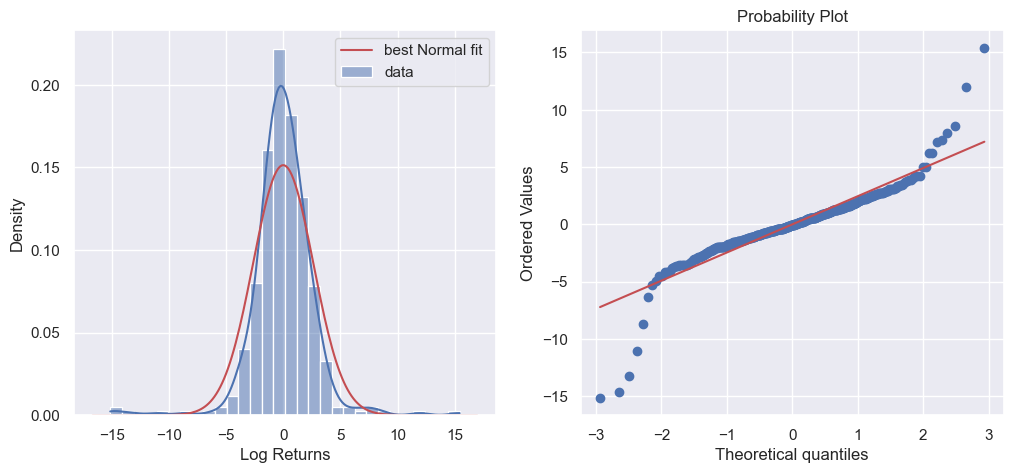

In [30]:
fig = hist_probplot(x, bins=30)

It is possible to use Student's $t$ distribution for the White Noise which is filtered in the GARCH model. To do so, set the parameter `dist='t'` in the construction of the `arch_model` object.  
See https://arch.readthedocs.io/en/latest/univariate/introduction.html#arch.univariate.arch_model.

### ARCH effect

Print the ACF and PACF of the standardized residuals in `res_garch11` and of their squares.

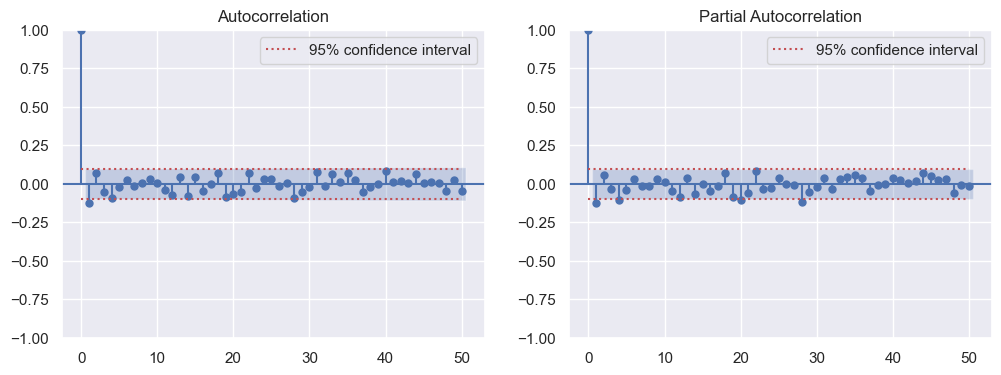

In [31]:
fig = acf_pacf(res_garch11.std_resid)

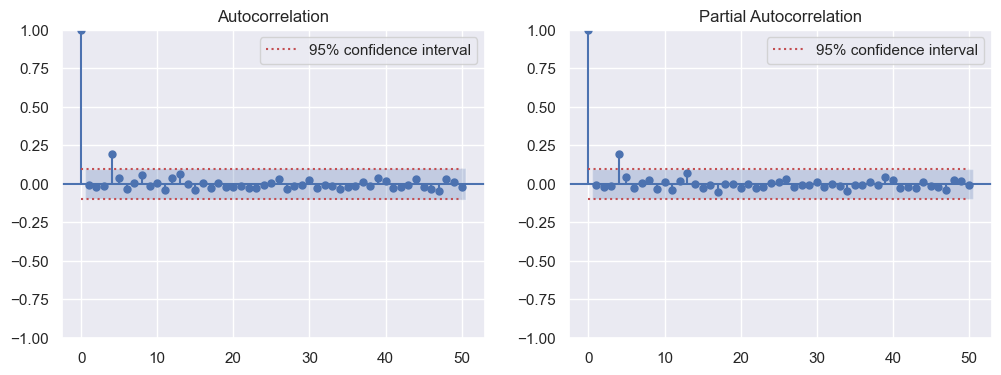

In [32]:
fig = acf_pacf(res_garch11.std_resid**2)

Use the Engle's test to confirm that there is no ARCH effect left in the standardized residuals.  
We conclude that the GARCH(1,1) model has **properly captured the ARCH effect**.

In [34]:
res = print_engle_test(res_garch11.std_resid)

Engle's ARCH Test


,test statistic,p-value
Lagrange Multiplier,17.3789,0.0664
F test,1.7664,0.0649


# Conditional and unconditional variance / volatility

The output of the `arch_model().fit()` function is an object of the class [`ARCHModelResult`](https://arch.readthedocs.io/en/latest/univariate/generated/arch.univariate.base.ARCHModelResult.html#arch.univariate.base.ARCHModelResult). Explore its methods and properties.

## Conditional volatility
Use the `plot()` method of the object `res_garch11`.

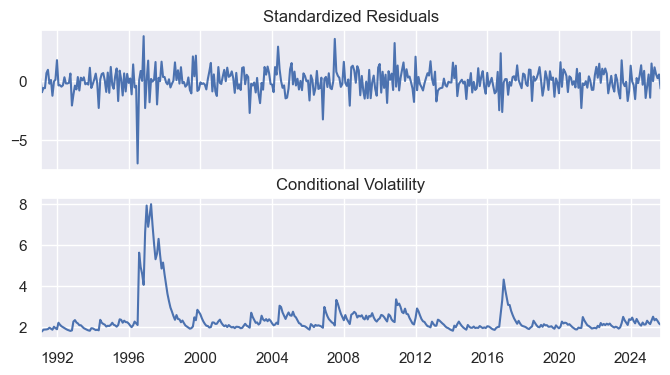

In [35]:
fig = res_garch11.plot()
fig.set_size_inches(8,4)

## Confidence interval
Create a DataFrame with the weekly returns, the in-sample conditional volatility, the upper and lower bounds of the 95% confidence interval and a boolean for the presence of an outlier.  
We need to extract from `res_t` the conditional volatility and the estimated degree of freedom.

In [36]:
df = x.to_frame(name='SP500').copy()
df['vol'] = res_garch11.conditional_volatility
df['upper'] = stats.norm.ppf(0.975) * df['vol']
df['lower'] = -df['upper']
df['outlier'] = (df['SP500'] > df['upper']) | (df['SP500'] < df['lower'])
df.head()

,SP500,vol,upper,lower,outlier
DATE,,,,,
1991-02-01,0.319387,1.791598,3.511468,-3.511468,False
1991-03-01,-1.691580,1.776388,3.481657,-3.481657,False
1991-04-01,-1.088460,1.862885,3.651187,-3.651187,False
1991-05-01,-1.126562,1.867724,3.660672,-3.660672,False
1991-06-01,1.273072,1.874210,3.673384,-3.673384,False


Plot the returns with the 95% confidence interval and highlight the returns which are outside this interval.

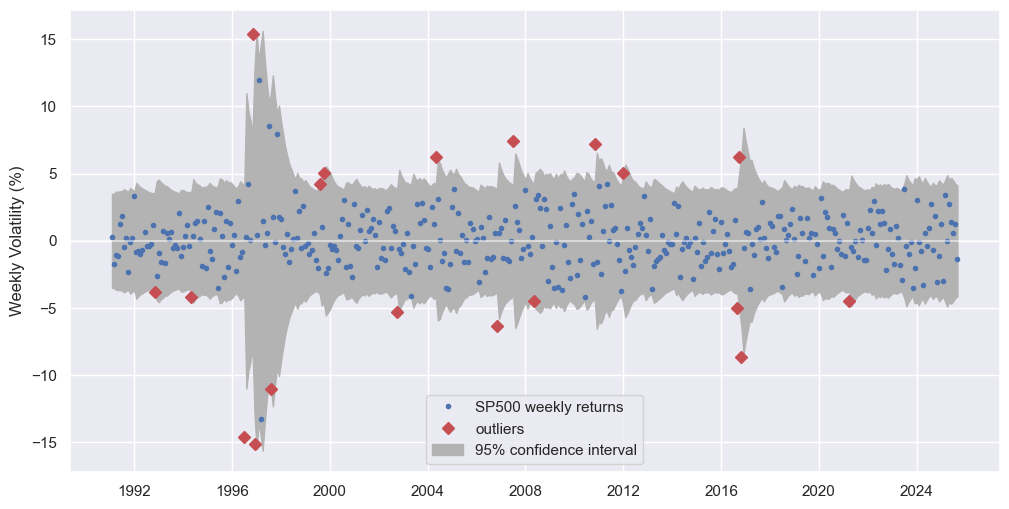

In [37]:
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(df['SP500'][~df['outlier']], 'b.', label='SP500 weekly returns')
ax.plot(df['SP500'][df['outlier']], 'rD', label='outliers')
ax.fill_between(x.index, df['lower'], df['upper'], color='0.7', label='95% confidence interval')
ax.axhline(0, c='w', alpha=0.5)

ax.set_ylabel('Weekly Volatility (%)')
ax.legend(loc='lower center');

## Unconditional variance of the fitted GARCH process

Compute the unconditional variance of the GARCH(1,1) process using the formula
$$\gamma(0)=\frac{\omega}{1-(\alpha+\beta)}$$  
Note that it isn't exaclty equal to the sample (or MLE of the) variance.

In [38]:
res_garch11.params

omega       0.758220
alpha[1]    0.128684
beta[1]     0.742785
Name: params, dtype: float64

In [39]:
uncond_var = res_garch11.params['omega'] / (1 - (res_garch11.params['alpha[1]']+res_garch11.params['beta[1]']))
print(f'Unconditional volatility of GARCH process = {np.sqrt(uncond_var):.5f}')
print(f'MLE of the volatility of returns          = {x.std(ddof=0):.5f}')

Unconditional volatility of GARCH process = 2.42881
MLE of the volatility of returns          = 2.63532


## Plot of the GARCH(1,1) conditional and unconditional volatilities

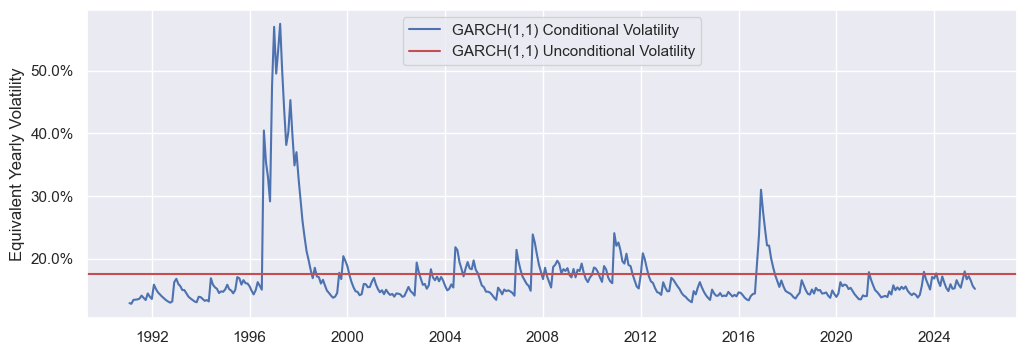

In [40]:
fig, ax = plt.subplots(figsize=(12,4))

ax.plot(res_garch11.conditional_volatility*math.sqrt(52) , label='GARCH(1,1) Conditional Volatility')
ax.axhline(np.sqrt(uncond_var)*math.sqrt(52) , color='r', label='GARCH(1,1) Unconditional Volatility')

ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylabel('Equivalent Yearly Volatility')
ax.legend(loc='upper center');

## Comparing with EWMA volatility
Use `alpha=1/5` and `alpha=1/50`. This is the weight of the most recent observation in the EWMA.  
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html  
https://pandas.pydata.org/pandas-docs/stable/user_guide/window.html#window-exponentially-weighted

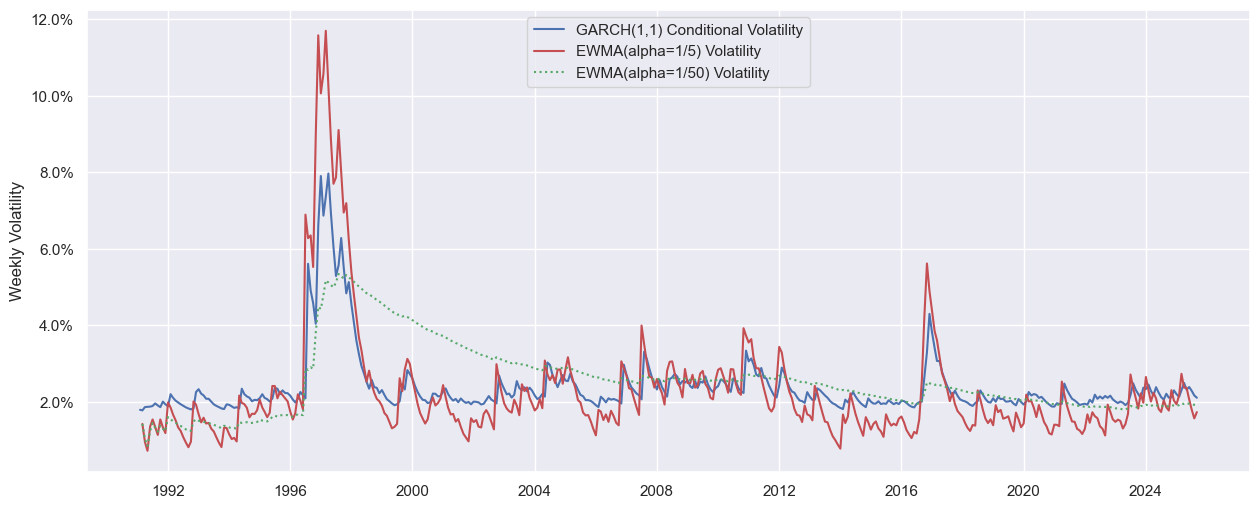

In [41]:
fig, ax = plt.subplots(figsize=(15,6))

ax.plot(res_garch11.conditional_volatility , label='GARCH(1,1) Conditional Volatility')
ax.plot(x.ewm(alpha=1/4).std(), c='r', label='EWMA(alpha=1/5) Volatility')
ax.plot(x.ewm(alpha=1/50).std(), c='g', ls=':', label='EWMA(alpha=1/50) Volatility')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylabel('Weekly Volatility')
ax.legend(loc='upper center');


# Forecasting conditional variance

Use the [`forecast()`](https://arch.readthedocs.io/en/latest/univariate/generated/generated/arch.univariate.base.ARCHModelResult.forecast.html) method of the [`ARCHModelResult`](https://arch.readthedocs.io/en/latest/univariate/generated/arch.univariate.base.ARCHModelResult.html#arch.univariate.base.ARCHModelResult) with a forecast horizon `horizon=100` and save the output which is a [`ARCHModelForecast`](https://arch.readthedocs.io/en/latest/univariate/forecasting.html#arch.univariate.base.ARCHModelForecast) object. Explore its methods and properties. Note especially the shape of the conditional variance.

In [42]:
f = res_garch11.forecast(horizon=100, reindex=True)

In [43]:
f.variance

,h.001,h.002,h.003,h.004,h.005,h.006,h.007,h.008,h.009,h.010,...,h.091,h.092,h.093,h.094,h.095,h.096,h.097,h.098,h.099,h.100
DATE,,,,,,,,,,,,,,,,,,,,,
1991-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
f.variance.iloc[-1]

h.001    4.286046
h.002    4.493376
h.003    4.674057
h.004    4.831516
h.005    4.968736
           ...   
h.096    5.899113
h.097    5.899113
h.098    5.899114
h.099    5.899114
h.100    5.899114
Name: 2025-09-01 00:00:00, Length: 100, dtype: float64

This function store the conditional volatility forecasts in a `pandas` `Series`. The computation of the forecasts' dates needs some attention.

In [45]:
def garch_cond_vol_forecast(model_forecast):
    """
    For a GARCH model
    Return a pandas Dataframe with forecasts of conditional volatility
    index starts on the next date after forecast_date according to the frequency of the data
    """
    # retrieve frequency of data
    freq = model_forecast.variance.index.freq
    # retrieve forecast horizon
    horizon = model_forecast.variance.shape[1]
    
    # compute conditional volatility
    vol = np.sqrt(model_forecast.variance.iloc[-1].values)
    
    # generates the dates at which the forecasts are computed
    # the first date being the last date of the dataset is ignored
    d = pd.date_range(model_forecast.variance.index[-1], periods=horizon+1, freq=freq)[1:]
    
    return pd.Series(data=vol, index=d)
  

Apply this function to store the forecasts, then plot these forecasts to see the convergence toward the unconditional volatility.

In [46]:
vol_forecast = garch_cond_vol_forecast(f)

In [47]:
vol_forecast

2025-09-02    2.070277
2025-09-03    2.119758
2025-09-04    2.161957
2025-09-05    2.198071
2025-09-06    2.229066
                ...   
2025-12-06    2.428809
2025-12-07    2.428809
2025-12-08    2.428809
2025-12-09    2.428809
2025-12-10    2.428809
Freq: D, Length: 100, dtype: float64

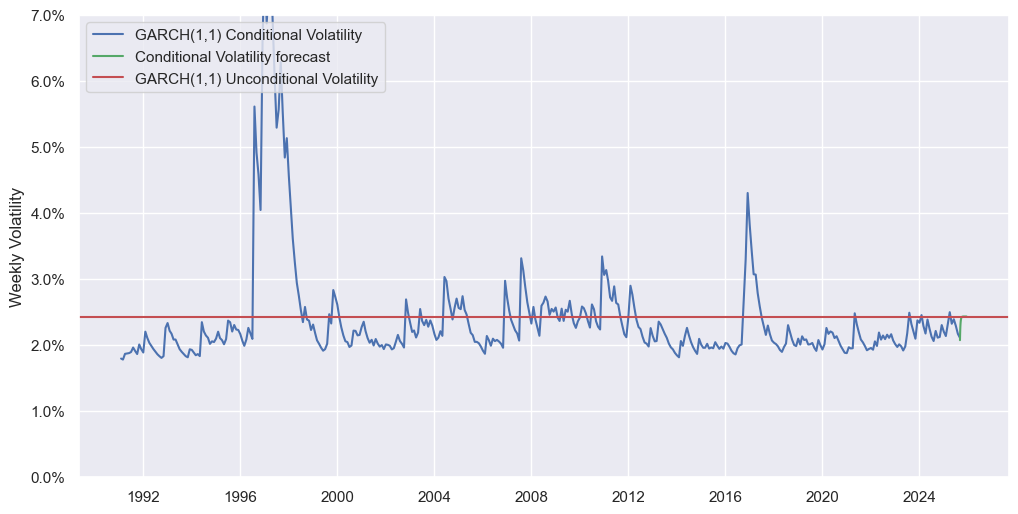

In [48]:
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(res_garch11.conditional_volatility, label='GARCH(1,1) Conditional Volatility')
ax.plot(vol_forecast, 'g', label='Conditional Volatility forecast')
ax.axhline(np.sqrt(uncond_var), color='r', label='GARCH(1,1) Unconditional Volatility')

ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylabel('Weekly Volatility')
ax.set_ylim([0, 7])
ax.legend(loc='upper left');